# Utils

## Install Prerequisites

In [ ]:
pip install pyspellchecker

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Import Libraries

In [ ]:
import pandas as pd
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from spellchecker import SpellChecker

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Download Packages

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Implement Functions

In [ ]:
def correct_types(df, columns):
    """
    Preprocess the specified columns in a DataFrame by replacing NaN values with an empty string
    and converting non-string values to string objects.

    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - column (str): The column to be preprocessed. Default is 'SO_Omschrijving'.

    Returns:
    - pd.DataFrame: The DataFrame with the specified column preprocessed.
    """

    df[columns] = df[columns].fillna('')
    df[columns] = df[columns].astype(str)
    return df

def replace_punctuation_text(text):
    """
    Replace punctuation in the input text.

    Parameters:
    - text (str): The input text in which punctuation will be replaced.

    Returns:
    - str: The input text with punctuation replaced.
    """
    # Replace "'s" with empty space.
    text = text.replace("'s", '')

    # Create a translation table to replace '.' and "'" with empty space, and other punctuation with spaces.
    translator = str.maketrans({'.': '', "'": '', **{p: ' ' for p in string.punctuation if p not in ['.', "'"]}})

    cleaned_text = text.translate(translator)

    return cleaned_text

def replace_punctuation(df, columns):
    """
    Replaces specific punctuation in the specified columns of a DataFrame.

    This function is designed to clean textual data in the specified columns of a DataFrame by:
    - Replacing occurrences of "'s" with an empty string.
    - Replacing periods (.) and apostrophes (') with an empty string.
    - Replacing other punctuation marks with a space.

    Args:
        df (pd.DataFrame): The DataFrame containing the columns to be cleaned.
        columns (list or str): The column name(s) of the DataFrame where the replacements should be applied.

    Returns:
        pd.DataFrame: The DataFrame with the specified columns cleaned of certain punctuation marks.
    """
    # Replace "'s" with an empty string in the specified columns.
    df[columns] = df[columns].replace("'s", '', regex=True)

    # Create a translation table to replace '.' and "'" with empty space,
    # and other punctuation with spaces.
    translator = str.maketrans({
        '.': '',                # Remove periods
        "'": '',                # Remove apostrophes
        **{p: ' ' for p in string.punctuation if p not in ['.', "'"]}  # Replace other punctuation with space
    })

    # Apply the translation table to each element in the specified columns.
    df[columns] = df[columns].applymap(lambda x: x.translate(translator))

    return df

def remove_numerical_values_text(text):
    """
    Remove numbers and model-related patterns from the input text.

    Parameters:
    - text (str): The input text from which numbers and model-related patterns will be removed.

    Returns:
    - str: The input text with numbers and model-related patterns removed.
    """
    # Remove standalone numbers with optional floating points; such as 154, 99.31.
    text = re.sub(r'\b\d+(\.\d+)?\b', '', text)

    # Remove ordinal numbers; such as 1e, 2ste, 3de, 4e.
    text = re.sub(r'\b\d+(e|ste|de|e)\b', '', text)

    # Remove numerical quantifiers; such as 1x OH.
    text = re.sub(r'\b\d+[xX]\b', '', text)

    return text

def remove_numerical_values(df, columns):
    """
    Removes various forms of numerical values from the specified columns in a DataFrame.

    This function cleans textual data in the specified columns by:
    - Removing standalone numbers with optional floating points (e.g., 154, 99.31).
    - Removing ordinal numbers commonly used in Dutch (e.g., 1e, 2ste, 3de, 4e).
    - Removing numerical quantifiers with 'x' (e.g., 1x, 2X).

    Args:
        df (pd.DataFrame): The DataFrame containing the columns to be cleaned.
        columns (list or str): The column name(s) of the DataFrame where the numerical values should be removed.

    Returns:
        pd.DataFrame: The DataFrame with the specified columns cleaned of numerical values.
    """
    # Remove standalone numbers with optional floating points (e.g., 154, 99.31).
    df[columns] = df[columns].applymap(lambda x: re.sub(r'\b\d+(\.\d+)?\b', '', x))

    # Remove ordinal numbers (e.g., 1e, 2ste, 3de, 4e).
    df[columns] = df[columns].applymap(lambda x: re.sub(r'\b\d+(e|ste|de)\b', '', x))

    # Remove numerical quantifiers (e.g., 1x, 2X).
    df[columns] = df[columns].applymap(lambda x: re.sub(r'\b\d+[xX]\b', '', x))

    return df

def stemize(text):
    """
    Perform stemming on the input text using the Dutch Snowball Stemmer.

    Parameters:
    - text (str): The input text to be stemmed.

    Returns:
    str: The stemmed text.

    Example:
    >>> stemize("This is an example text for stemming.")
    'thi is an exampl text for stem.'
    """
    stemmer = SnowballStemmer("dutch")
    tokens = word_tokenize(text)
    text = ' '.join([stemmer.stem(token) for token in tokens])
    return text

def normalize_lookups():
    """
    Normalize and preprocess the global lookup lists.

    This function performs the following operations on each global lookup list:
    1. Orders lookup lists by length in descending order.
    2. Initializes the Dutch Snowball Stemmer.
    3. Replaces punctuations using the `replace_punctuation` function.
    4. Removes numerical values using the `remove_numerical_values` function.
    5. Applies stemming using the `stemize` function.
    6. Converts the resulting list to a set.

    Note: The original lookup lists are modified in-place.

    Returns:
    None
    """
    # Get all lookup lists using regular expression.
    lookup_lists = [var for var in globals() if re.match(r'^lookup_', var)]
    lookup_ventilation_lists = [var for var in globals() if re.match(r'^sublookup_', var)]

    for lookup_list_name in lookup_lists:

        lookup_list = globals()[lookup_list_name]

        # Replace punctuations, remove numerical values, and apply stemming.
        normalized_list = [stemize(remove_numerical_values_text(replace_punctuation_text(word))) for word in lookup_list]

        # Convert to set.
        lookup_list.clear()
        lookup_list.extend(set(normalized_list))

    for lookup_list_name in lookup_ventilation_lists:

        lookup_list = globals()[lookup_list_name]

        # Replace punctuations, remove numerical values, and apply stemming.
        normalized_list = [stemize(remove_numerical_values_text(replace_punctuation_text(word))) for word in lookup_list]

        # Convert to set.
        lookup_list.clear()
        lookup_list.extend(set(normalized_list))

def group_modules(description, lookup_lists):
    """
    Classifies a description into a module type based on predefined lookup lists.

    This function checks if the given description contains any words from a set of lookup lists
    and assigns a module type accordingly. The lookup lists are accessed dynamically using their
    names, and the corresponding module type is identified using a separate mapping.

    Args:
        description (str): The text description to be classified.
        lookup_lists (list of str): A list of lookup list names to check against the description.

    Returns:
        str: The identified module type name if a match is found; otherwise, 'Other'.
    """
    # Convert the description to lowercase to ensure case-insensitive matching.
    description = description.lower()

    # Iterate through each lookup list name in the provided list.
    for lookup_list_name in lookup_lists:
        # Access the actual lookup list using the global variable name.
        lookup_list = globals().get(lookup_list_name)

        # Check if any word in the lookup list is present in the description.
        for word in lookup_list:
            if word.lower() in description:
                # Map the lookup list name to its corresponding module type.
                type_name = module_names[lookup_list_name.split('_')[1]]
                return type_name  # Return the matched module type.

    # Return 'Other' if no matching word is found in the lookup lists.
    return 'Other'

def rules_to_coordinates(rules):
    """
    Convert association rules to coordinates.

    Parameters:
    - rules (pd.DataFrame): DataFrame containing association rules with 'antecedents', 'consequents', and other columns.

    Returns:
    - pd.DataFrame: DataFrame with 'antecedent', 'consequent', and 'rule' columns representing coordinates.
    """

    # Extract the first item from antecedents and consequents.
    rules['antecedent'] = rules['antecedents'].apply(lambda antecedent: list(antecedent)[0])
    rules['consequent'] = rules['consequents'].apply(lambda consequent: list(consequent)[0])

    # Assign rule index to a new column 'rule'.
    rules['rule'] = rules.index

    # Select relevant columns for coordinates.
    coords = rules[['antecedent', 'consequent', 'rule']]

    return coords

def contains_word_regex(sentence, target_word):
    """
    Check if a given word is present in a sentence using regex.

    Parameters:
    - sentence (str): The input sentence to check.
    - target_word (str): The word to look for in the sentence.

    Returns:
    - bool: True if the word is found, False otherwise.
    """
    # Construct a regex pattern to match the whole word, case-insensitive.
    pattern = r'\b' + re.escape(target_word) + r'\b'

    # Use re.search to find the pattern in the sentence.
    match = re.search(pattern, sentence, flags=re.IGNORECASE)

    # Return True if a match is found, False otherwise.
    return bool(match)

def convert_str_to_set(itemset_str):
    """
    Converts a comma-separated string into a set of items.

    This function takes a string containing items separated by commas,
    strips any surrounding whitespace from each item, and returns a set
    containing the unique items. This is useful for converting textual
    representations of itemsets into Python set objects for further analysis.

    Args:
        itemset_str (str): A string of items separated by commas.

    Returns:
        set: A set containing the stripped items from the input string.
    """
    # Split the string by commas and strip whitespace from each item.
    items = [item.strip() for item in itemset_str.split(',')]

    # Convert the list of items to a set to ensure uniqueness.
    return set(items)

def get_season(month):
    """
    Determine the season corresponding to a given month.
    Args:
        month (int): The month as an integer (1 for January, 2 for February, ..., 12 for December).
    Returns:
        str: The season name corresponding to the input month:
            - 'Winter' for December (12), January (1), February (2)
            - 'Spring' for March (3), April (4), May (5)
            - 'Summer' for June (6), July (7), August (8)
            - 'Fall' for September (9), October (10), November (11)
    Raises:
        ValueError: If the input month is not between 1 and 12.
    """
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'
    else:
        raise ValueError("Month must be an integer between 1 and 12.")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Define Lookup Tables

In [ ]:
lookup_ventilation = [
    "lbk",
    "luchtbehandeling",
    "luchtbehandelen",
    "luchbehandeling",
    "luchtbehandeling",
    "ventilatiesysteem",
    "ventilatie",
    "luchtklep",
    "stoombevochtiger",
    "stoombevochtiging",
    "bevochtiger",
    "toevoerventilator",
    "afvoerventilator",
    "ventilatormotor",
    "dakventilatoren",
    "Dakventilator",
    "toevoer ventilator",
    "dak ventilatoren",
    "Afzuiventilator",
    "wiel",
    "afzuigvent",
    "V-snaren",
    "V snaren",
    "filters",
    "snaarbreuk",
    "condensafvoer",
    "condensor",
    "filter",
    "Luchtbeh",
    "LBH",
    "vorst",
    "verwarmingsbatterij",
    "stoomvochtiger",
    "luchtdebiet",
    "luchtzakken",
    "fancoil",
    "fan coil",
    "fan-coil"
]

lookup_cooling = [
    "airco",
    "drogekoeler",
    "koelmachine",
    "koeling",
    "KM",
    "koelunit",
    "koelinstallatie",
    "topcooling",
    "gkw",
    "koeltoren",
    "chillers",
    "dry-cooler",
    "drycooler",
    "koelplafond",
    "koelklep",
    "koelwaterpomp",
    "carrier",
    "koel-unit",
    "DX koeler",
    "DX-koeler",
    "draaikoeler",
    "condensventilator",
    "chiller",
    "koelventilator",
    "Condensorventilator",
    "condensor",
    "split unit",
    "split-unit",
    "splitunit"
]

lookup_heating = [
    "ketel",
    "CV",
    "c.v.",
    "c.v",
    "Kachel",
    "verwarming",
    "radiatoren",
    "radiator",
    "vloerverwarming",
    "rookgasventilator"
]

lookup_fireSafety = [
    "brandmeld",
    "rookmelder",
    "branddeur",
    "brandklep",
    "brandweer",
    "brandhaspel",
    "brandblus",
    "ontruiming",
    "Brandventilatoren",
    "trappenhuis"
]

lookup_entrance = [
    "toegangspoort",
    "tourniqet",
    "paslezer","tourniquet",
    "tourniqeut",
    "tourniqut",
    "toegang",
    "Toerniqet",
    "tourniget",
    "garagedeur",
    "schuifhek",
    "slagboom"
]

lookup_shading = [
    "zonwering",
    "zonneschermen",
    "zonnewering"
]

lookup_sanitary = [
    "toilet",
    "WC",
    "urinoir",
    "wastafel",
    "sanitair",
    "wasbak",
    "afvoer"
]

lookup_heatPump = [
    "warmtepomp",
    "warmte pomp",
    "WKO"
]

lookup_lighting = [
    "verlichting",
    "lamp",
    "Tl-buis",
    "licht",
    "tlarmatuur",
    "tlbuizen",
    "armatuur",
    "armaturen",
    "armanturen"
]

lookup_elevator = [
    "Lift"
]

lookup_wkk = [
    "WKK"
]

lookup_bms = [
    "GBS",
    "Data",
    "logger",
    "lon",
    "BMC",
    "priva",
    "software",
    "regeling",
    "hardware",
    "regelkast",
    "RK 1",
    "rk5",
    "rk2",
    "RK5",
    "rk3",
    "Rk 3",
    "rk4",
    "rk 4",
    "rk1",
    "rk2",
    "rk6",
    "rk 6",
    "RK7",
    "sensor",
    "regelaar",
    "opnemer",
    "thermostaat",
    "meting",
    "onderstation",
    "Kloktijden",
    "kastventilatoren",
    "kastventilatoren",
    "kastventilator",
    "Kastventilator"
]

lookup_waterDistribution = [
    "regelklep",
    "driewegklep",
    "TSA",
    "Warmtewisselaar",
    "pomp",
    "hydrofoor",
    "expansie",
    "drukvat",
    "waterleiding",
    "3wegklep",
    "transportnet"
]

lookup_office = [
    "werkvoorbereiding",
    "Contractbeheerder",
    "materiaal",
    "Onderaanneming",
    "Werkvoorbereider",
    "kantoor",
    "Materiaalbon",
    "Urenbon",
    "Contractbegeleiding",
    "Contractbeheer",
    "overleg",
    "Meet-enregeltechniek",
    "Inlenen",
    "Weekplanning",
    "calculatie",
    "Onderaannemering",
    "contractmanager",
    "Contractmanagement",
    "Onderaannemer"
]

lookup_domesticWater = [
    "warm water",
    "ww",
    "w.w.",
    "w.w",
    "warmtapwater",
    "warmwater",
    "boiler"
]

lookup_faultRedemption = [
    "Storingsafkoop",
    "Afkoopstoringen",
    "Verrekening afkoop"
]

lookup_regularMaintenance = [
    "onderhoud",
    "inspectie",
    "OH",
    "OHD",
    "controle",
    "Preventief",
    "testen",
    "Bedrijfvoering",
    "Bedrijfsvoering"
]

lookup_complaints = [
    "klachten",
    "klacht",
    "te warm",
    "tekoud",
    "luchtvochtigheid",
    "klimaatbeheersing",
    "klimaat",
    "teheet",
    "benauwd",
    "tocht",
    "R.V.",
    "ergkoud",
    "RV telaag",
    "lekkage",
    "Ruimtevochtigheid",
    "erg warm",
    "erg koud"
]

module_names = {
    "complaints": "Complaints",
    "regularMaintenance": "Regular Maintenance",
    "faultRedemption": "Fault Redemption",
    "domesticWater": "Domestic Water",
    "office": "Office",
    "waterDistribution": "Water Distribution",
    "bms": "BMS",
    "wkk": "WKK",
    "elevator": "Elevator",
    "lighting": "Lighting",
    "heatPump": "Heat Pump",
    "sanitary": "Sanitary",
    "fireSafety": "Fire Safety",
    "shading": "Shading",
    "entrance": "Entrance",
    "ventilation": "Ventilation",
    "heating": "Heating",
    "cooling": "Cooling",
}

normalize_lookups()

# Get the list of all of the lookups.
list_lookups = [var for var in globals() if re.match(r'^lookup_', var)]

# Sort the lookups descendingly based on their lengths.
list_lookups = sorted(list_lookups, key=lambda x: len(globals()[x]), reverse=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Data Reading

In [ ]:
# Define the path to the dataset here.
path = '/content/drive/MyDrive/Colab Notebooks/Navision Serviceorder data.xlsx'

df_so = pd.read_excel(path)
df_so.reset_index(drop=True, inplace=True)
columns_to_select = ['SO_Omschrijving', 'Probleemtekst', 'Oorzaaktekst', 'Oplossingstekst', 'SO_Orderdatum (Begindatum)', 'Order technisch gereed (Einddatum)', 'Factuurkosten SO']
df_so = df_so[columns_to_select]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Exploratory Data Analysis

## Data Cleaning

In [ ]:
textual_columns = ['SO_Omschrijving', 'Probleemtekst', 'Oorzaaktekst', 'Oplossingstekst']

# Correct cell value types.
df_so_cleaned = correct_types(df_so.copy(), textual_columns)

# Replace punctuations.
df_so_cleaned = replace_punctuation(df_so_cleaned, textual_columns)

# Remove numerical values.
df_so_cleaned = remove_numerical_values(df_so_cleaned, textual_columns)

# Remove Dutch stop words.
stop_words = set(stopwords.words('dutch'))
stop_words.add('via')
stop_words.remove('niet')
df_so_cleaned[textual_columns] = df_so_cleaned[textual_columns].applymap(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words]))

# Stemize the text.
df_so_cleaned[textual_columns] = df_so_cleaned[textual_columns].applymap(stemize)

df_so_cleaned.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-10-c7f656a0af14>:66: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[columns] = df[columns].applymap(lambda x: x.translate(translator))
<ipython-input-10-c7f656a0af14>:108: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[columns] = df[columns].applymap(lambda x: re.sub(r'\b\d+(\.\d+)?\b', '', x))
<ipython-input-10-c7f656a0af14>:111: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[columns] = df[columns].applymap(lambda x: re.sub(r'\b\d+(e|ste|de)\b', '', x))
<ipython-input-10-c7f656a0af14>:114: FutureWarning:

,SO_Omschrijving,Probleemtekst,Oorzaaktekst,Oplossingstekst,SO_Orderdatum (Begindatum),Order technisch gereed (Einddatum),Factuurkosten SO
0,storing stoombevochtiger ruimt,grag storing stoombevochtiger doorgevenhet bet...,niet duidelijk,cod 5b stat drainag foutendiver component geco...,2022-02-16,2022-02-17,154.18
1,wasbak pantry ruimt loopt slecht,wasbak pantry ruimt derd verdiep loopt slecht ...,technisch gebrek,afvoer pantry erg vervuild zie foto schoongema...,2022-03-04,2022-03-04,229.58
2,storing bevochtiger lbk link,storing bevochtiger lbk linksafwijk w,technisch gebrek,ingebeld storing geaccepteerd vanaf afstand ni...,2022-03-07,2022-03-08,188.14
3,afzuig schakelar werkt niet keuk,afzuig schakelar werkt niet keukenafwijk w,technisch gebrek,afzuig kap kookeiland werkt niet regelkast gek...,2022-05-23,2022-05-23,250.17
4,snaarbreuk afzuigvent lbk recht,gegenereerd gbsdatum tijd 50system sl138278 ge...,technisch gebrek,gaarn locatie beoordel herstellenfunctionel he...,2022-06-30,2022-07-04,447.16


## Data Annotation

In [ ]:
# Apply the 'group_modules' function to categorize each service order (SO) description into a main subsystem (module).
# The 'target' column will store the assigned subsystem label for each service order based on the lookup tables.
df_so_cleaned['target'] = df_so_cleaned['SO_Omschrijving'].apply(lambda description: group_modules(str(description), list_lookups))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


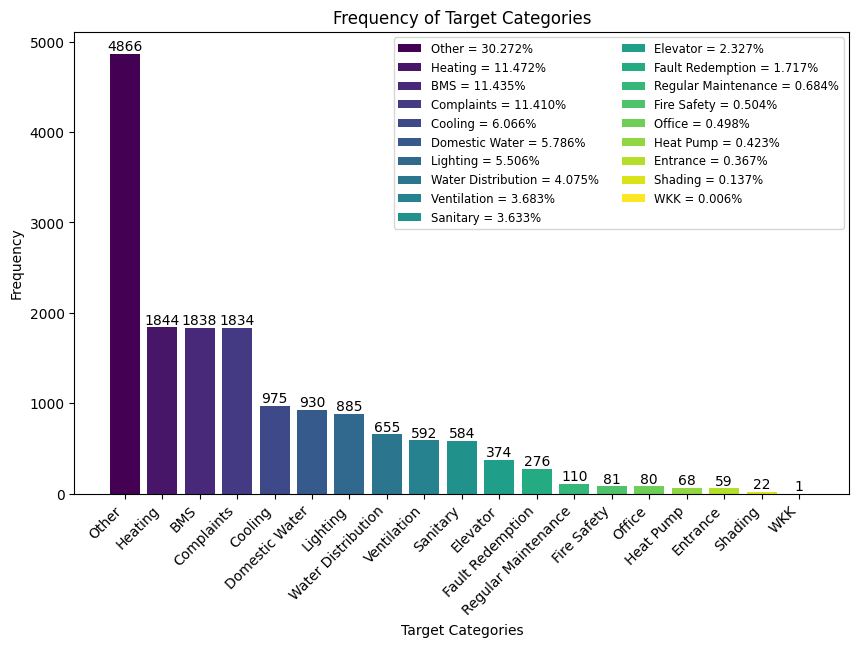

In [ ]:
# Calculate the counts for each target category.
target_counts = df_so_cleaned["target"].value_counts()

# Calculate the total number of samples.
total_samples = len(df_so_cleaned)

# Plotting the bar chart.
plt.figure(figsize=(10, 6))
bars = plt.bar(target_counts.index, target_counts, color=plt.cm.viridis(np.linspace(0, 1, len(target_counts))))
plt.title("Frequency of Target Categories")
plt.xlabel("Target Categories")
plt.ylabel("Frequency")
plt.xticks(rotation=45, ha='right')
plt.yticks(minor=True)

# Add counts on top of the bars.
for bar, count in zip(bars, target_counts):
    plt.text(bar.get_x() + bar.get_width() / 2, count + 1, str(count), ha='center', va='bottom')

# Calculate and format percentages for legend labels.
percentages = [(f"{category} = {count/total_samples*100:.3f}%") for category, count in target_counts.items()]

# Add legend with custom labels.
plt.legend(bars, percentages, loc='upper right', bbox_to_anchor=(1, 1), ncol=2, fontsize='small')

plt.savefig('/content/drive/MyDrive/Kropman/figures/Annotation (Classification)/module_categories.png', bbox_inches = 'tight')
plt.show()

## Keep Original Description Column (SO_Omschrijving)

In [ ]:
df_so_cleaned['original_sentence'] = df_so['SO_Omschrijving']

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Get Cooling Data

In [ ]:
df_so_cleaned_cooling = df_so_cleaned[df_so_cleaned['target'] == 'Cooling']

df_so_cleaned_cooling.info()

<class 'pandas.core.frame.DataFrame'>
Index: 975 entries, 25 to 16045
Data columns (total 9 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   SO_Omschrijving                     975 non-null    object        
 1   Probleemtekst                       975 non-null    object        
 2   Oorzaaktekst                        975 non-null    object        
 3   Oplossingstekst                     975 non-null    object        
 4   SO_Orderdatum (Begindatum)          975 non-null    datetime64[ns]
 5   Order technisch gereed (Einddatum)  928 non-null    datetime64[ns]
 6   Factuurkosten SO                    975 non-null    float64       
 7   target                              975 non-null    object        
 8   original_sentence                   975 non-null    object        
dtypes: datetime64[ns](2), float64(1), object(6)
memory usage: 76.2+ KB


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df_so_cleaned_cooling.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,SO_Omschrijving,Probleemtekst,Oorzaaktekst,Oplossingstekst,SO_Orderdatum (Begindatum),Order technisch gereed (Einddatum),Factuurkosten SO,target,original_sentence
25,computair ruimt koeling plas water server,server ruimt computair ruimt koeling lekkag zi...,terugkoppel western airco oud sport lekkag nie...,terugkoppel western airo 8lekkag vloer lek wat...,2023-08-02,2023-08-10,218.68,Cooling,Computair ruimte onder koeling plas water. Server
56,rookmelder toevoer rookkanal functioneerd niet,rookmelder toevoer rookkanal functioneerd niet...,technisch gebrektechnisch gebrek,material besteld rookmelder vervuild spoed nie...,2019-05-29,2019-06-14,993.45,Cooling,Rookmelder in toevoer rookkanaal functioneerd ...
59,airco unit lijkt strom krijg,airco unit lijkt strom krijg mener schakelar d...,,valt niet kropman mevrouw gat juist partij ben...,2019-09-27,NaT,0.00,Cooling,Airco-unit lijkt geen stroom te krijgen
60,lekkag airco binnendel,contactperson kevin tiboschcondenspompj sensor...,technisch gebrek,nazien lekkag gevel kwam vanuit ac unit conden...,2019-09-27,2019-10-11,702.68,Cooling,lekkage airco binnendeel
61,rookmelder toevoer rookkanal functioneerd niet,rookmelder toevoer rookkanal functioneerd niet...,technisch gebrektechnisch gebrek,material besteld rookmelder vervuild spoed nie...,2019-10-14,2019-10-14,0.00,Cooling,Rookmelder in toevoer rookkanaal functioneerd ...


## Visualization on SO_Omschrijving

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


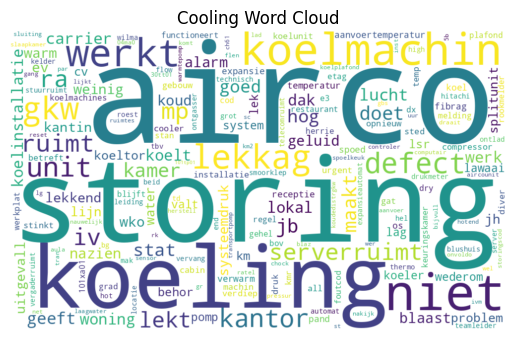

In [ ]:
# Extract the 'SO_Omschrijving' (service order description) for all service orders categorized under 'Cooling'.
# Store them as a list for further processing in text analysis.
corpus_cooling = df_so_cleaned_cooling[df_so_cleaned_cooling['target'] == 'Cooling']['SO_Omschrijving'].tolist()

# Initialize a CountVectorizer to convert the heating-related descriptions into a document-term matrix (DTM).
# We are specifying that we only want to extract unigrams (individual words) with ngram_range=(1, 1).
vectorizer_cooling = CountVectorizer(ngram_range=(1, 1))

# Fit the vectorizer to the corpus and transform it into a DTM (a matrix of word counts).
dtm_cooling = vectorizer_cooling.fit_transform(corpus_cooling)

# Retrieve the feature names (terms) from the vectorizer (i.e., the words in the DTM).
terms_cooling = vectorizer_cooling.get_feature_names_out()

# Convert the DTM into a DataFrame where each column corresponds to a word and each row represents a service order.
dtm_cooling = pd.DataFrame(dtm_cooling.toarray(), columns=terms_cooling)

# Calculate the frequency of each term by summing over the columns of the DTM.
term_frequencies_cooling = dtm_cooling.sum()

# Generate a word cloud based on the term frequencies for the heating-related service orders.
wordcloud = WordCloud(width=1000, height=600, background_color='white').generate_from_frequencies(term_frequencies_cooling)

# Display the word cloud.
plt.title('Cooling Word Cloud')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

# Save the generated word cloud image to the specified directory. Change this in case of need!
plt.savefig('/content/drive/MyDrive/Kropman/figures/EDA/cooling_terms_word_cloud.png')

# ARM

## Obtain Pruned Association Rules

In [ ]:
# Step 1: Split each service order description in the 'SO_Omschrijving' column into individual words for the ventilation component.
transactions_cooling = df_so_cleaned_cooling[df_so_cleaned_cooling['target'] == 'Cooling']['SO_Omschrijving'].apply(lambda t: t.split(' '))

# Convert the series of lists into a list of transactions (each transaction is a list of words).
transactions_cooling = list(transactions_cooling)

# Step 2: Apply one-hot encoding to the transactions using the TransactionEncoder.
encoder_cooling = TransactionEncoder().fit(transactions_cooling)
onehot_cooling = encoder_cooling.transform(transactions_cooling)
onehot_cooling = pd.DataFrame(onehot_cooling, columns=encoder_cooling.columns_)

# Step 3: Define the minimum support threshold for finding frequent itemsets.
'''
Define the minimum number of occurrences for each itemset.
This indirectly acts as a hyperparamether, so tune it as you pefer.
Increase the value of "n" if you want to find more frequent itemsets.
Decrease the value of "n" if you want to find less frequent itemsets.
'''
n = 20
minimum_support = n/len(onehot_cooling) # Calculate the minimum support as the ratio of 'n' to the total number of transactions.

# Step 4: Run the Apriori algorithm to identify frequent itemsets based on the minimum support threshold.
frequent_itemsets_cooling = apriori(onehot_cooling,
                            min_support =  minimum_support,
                            use_colnames = True,
                            verbose = 1)

# Step 5: Generate association rules from the frequent itemsets using the 'lift' metric with a minimum threshold of 1.
rules_cooling = association_rules(frequent_itemsets_cooling, metric = 'lift', min_threshold = 1)

# Print summary statistics of the process.
print(f'Number of transactions: {len(onehot_cooling)}')
print(f'Minimum number of occurrence for each itemset: {n}')
print(f'Minimum support threshold for itemsets: {minimum_support}')
print(f'number of frequent itemsets: {len(frequent_itemsets_cooling)}')
print(f'Number of rules: {len(rules_cooling)}\n')

# Step 6: Replace frozen sets with strings for easier readability in the rules.
rules_cooling['antecedents'] = rules_cooling['antecedents'].apply(lambda a: ','.join(list(a)))
rules_cooling['consequents'] = rules_cooling['consequents'].apply(lambda a: ','.join(list(a)))

# Display the final association rules.
rules_cooling

Processing 303 combinations | Sampling itemset size 3
Number of transactions: 975
Minimum number of occurrence for each itemset: 20
Minimum support threshold for itemsets: 0.020512820512820513
number of frequent itemsets: 45
Number of rules: 46



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,defect,airco,0.051282,0.500513,0.034872,0.680000,1.358607,0.009204,1.560897,0.278219
1,airco,defect,0.500513,0.051282,0.034872,0.069672,1.358607,0.009204,1.019767,0.528445
2,airco,iv,0.500513,0.035897,0.024615,0.049180,1.370023,0.006648,1.013970,0.540726
3,iv,airco,0.035897,0.500513,0.024615,0.685714,1.370023,0.006648,1.589277,0.280142
4,airco,kantor,0.500513,0.042051,0.032821,0.065574,1.559376,0.011773,1.025173,0.718172
5,kantor,airco,0.042051,0.500513,0.032821,0.780488,1.559376,0.011773,2.275442,0.374465
6,airco,lekkag,0.500513,0.071795,0.053333,0.106557,1.484192,0.017399,1.038908,0.653135
7,lekkag,airco,0.071795,0.500513,0.053333,0.742857,1.484192,0.017399,1.942450,0.351466
8,lekt,airco,0.031795,0.500513,0.025641,0.806452,1.611251,0.009727,2.580684,0.391822
9,airco,lekt,0.500513,0.031795,0.025641,0.051230,1.611251,0.009727,1.020484,0.759507


## Heatmap of support

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


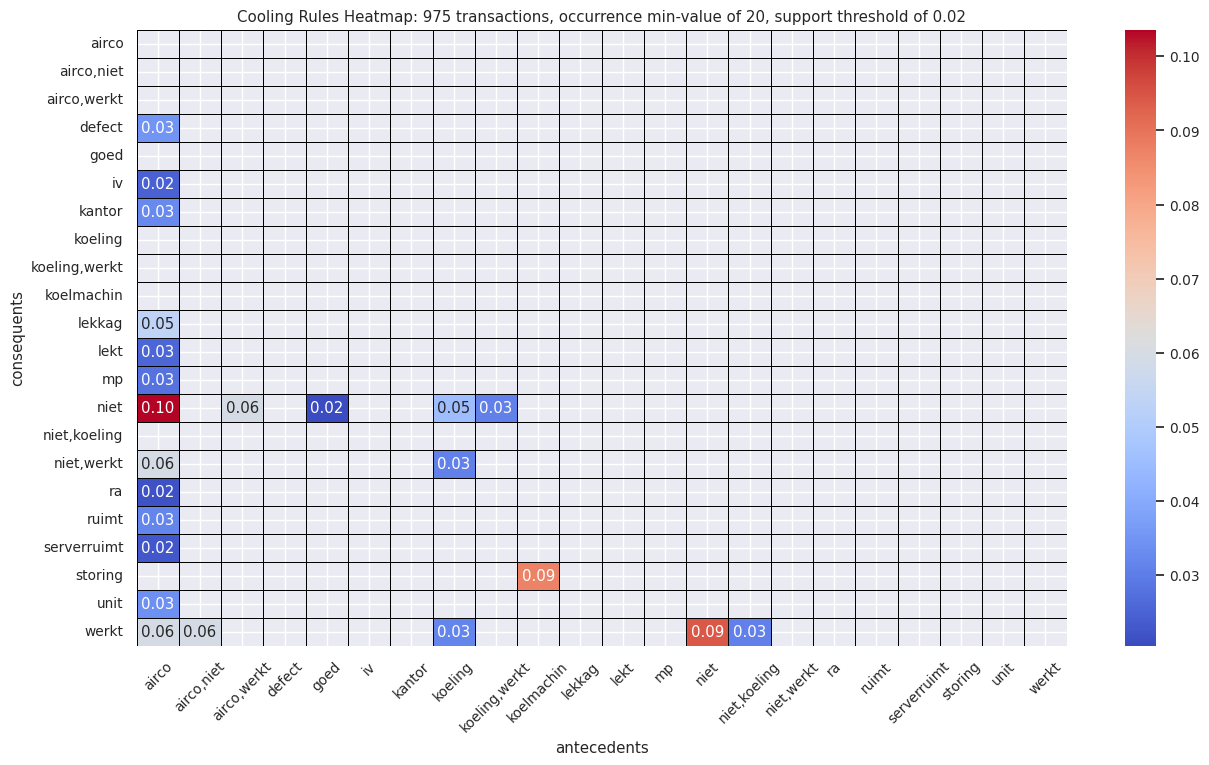

In [ ]:
# Step 1: Transform the association rules data into a pivot table for the heatmap.
# The pivot table uses 'consequents' as the row index and 'antecedents' as the columns, with 'support' values as the matrix.
pivot = rules_cooling.pivot(index='consequents', columns='antecedents', values='support')

# Step 2: Create a mask for the upper triangle of the heatmap to avoid duplicate values being displayed.
mask = np.triu(np.ones_like(pivot, dtype=bool))

# Step 3: Set the font scale for the heatmap.
sns.set(font_scale=0.9)

# Step 4: Create the heatmap figure.
plt.figure(figsize=(15, 8))

# Step 5: Generate the heatmap using seaborn.
heatmap = sns.heatmap(pivot,  # The pivot table containing support values.
                      cmap='coolwarm',  # Use the 'coolwarm' color palette.
                      mask=mask,  # Apply the mask to hide the upper triangle of the heatmap.
                      cbar=True,  # Show the color bar indicating the support values.
                      linewidths=0.5,  # Set the width of the grid lines.
                      linecolor='black',  # Set the color of the grid lines.
                      annot=True,  # Annotate each cell with the support value.
                      fmt='.2f')  # Format the annotations to two decimal places.

# Step 6: Customize the heatmap.
plt.xticks(rotation=45) # Rotate the x-axis labels 45 degrees for better readability.
plt.title(f'Cooling Rules Heatmap: {len(onehot_cooling)} transactions, occurrence min-value of {n}, support threshold of {minimum_support:.2f}') # Set the heatmap title.
plt.yticks(rotation=0) # Keep the y-axis labels horizontal.

# Step 7: Save the heatmap as an image file. Change the output path in case of need!
plt.savefig('/content/drive/MyDrive/Kropman/figures/Association Rule Mining/cooling/support_heatmap.png')

# Step 8: Display the heatmap.
plt.show()

## Heatmap of leverage

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


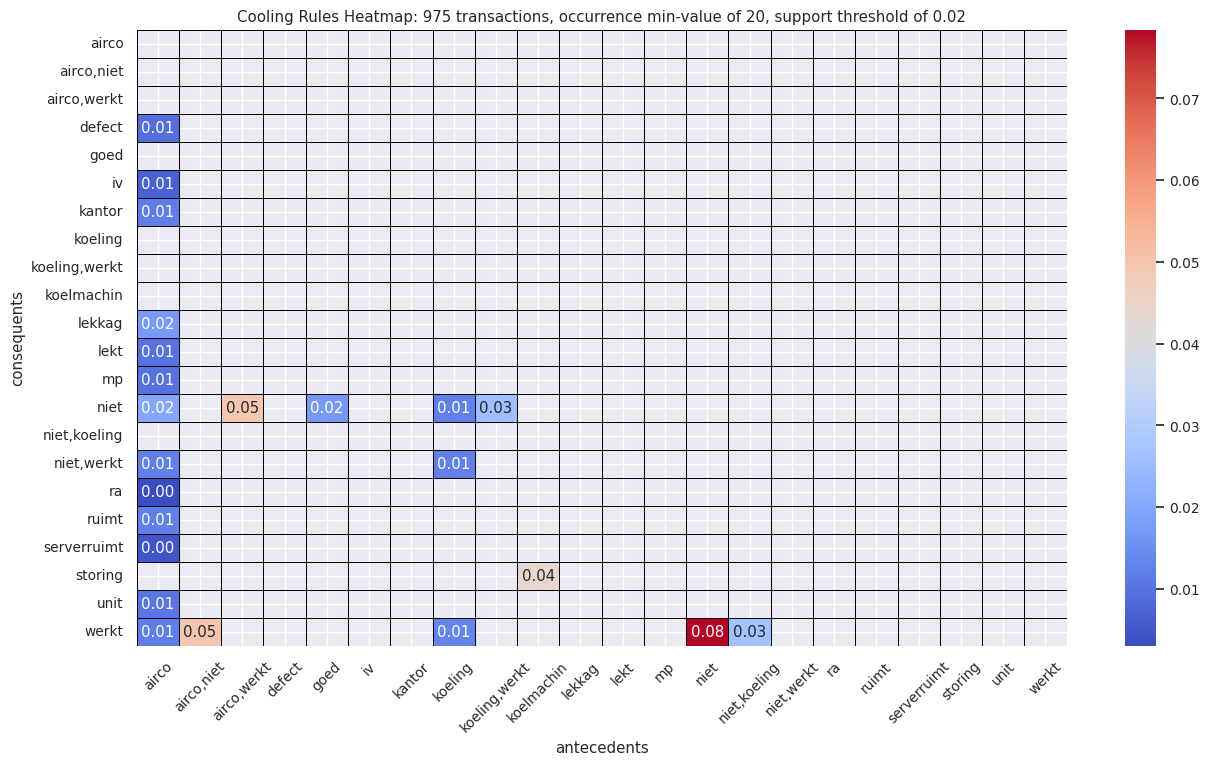

In [ ]:
# Step 1: Transform the association rules data into a pivot table for the heatmap.
# The pivot table uses 'consequents' as the row index and 'antecedents' as the columns, with 'leverage' values as the matrix.
pivot = rules_cooling.pivot(index='consequents', columns='antecedents', values='leverage')

# Step 2: Create a mask for the upper triangle of the heatmap to avoid duplicate values being displayed.
mask = np.triu(np.ones_like(pivot, dtype=bool))

# Step 3: Set the font scale for the heatmap.
sns.set(font_scale=0.9)

# Step 4: Create the heatmap figure.
plt.figure(figsize=(15, 8))

# Step 5: Generate the heatmap using seaborn.
heatmap = sns.heatmap(pivot,  # The pivot table containing support values.
                      cmap='coolwarm',  # Use the 'coolwarm' color palette.
                      mask=mask,  # Apply the mask to hide the upper triangle of the heatmap.
                      cbar=True,  # Show the color bar indicating the support values.
                      linewidths=0.5,  # Set the width of the grid lines.
                      linecolor='black',  # Set the color of the grid lines.
                      annot=True,  # Annotate each cell with the support value.
                      fmt='.2f')  # Format the annotations to two decimal places.

# Step 6: Customize the heatmap.
plt.xticks(rotation=45) # Rotate the x-axis labels 45 degrees for better readability.
plt.title(f'Cooling Rules Heatmap: {len(onehot_cooling)} transactions, occurrence min-value of {n}, support threshold of {minimum_support:.2f}') # Set the heatmap title.
plt.yticks(rotation=0) # Keep the y-axis labels horizontal.

# Step 7: Save the heatmap as an image file. Change the output path in case of need!
plt.savefig('/content/drive/MyDrive/Kropman/figures/Association Rule Mining/cooling/leverage_heatmap.png')

# Step 8: Display the heatmap.
plt.show()

## Heatmap of conviction

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


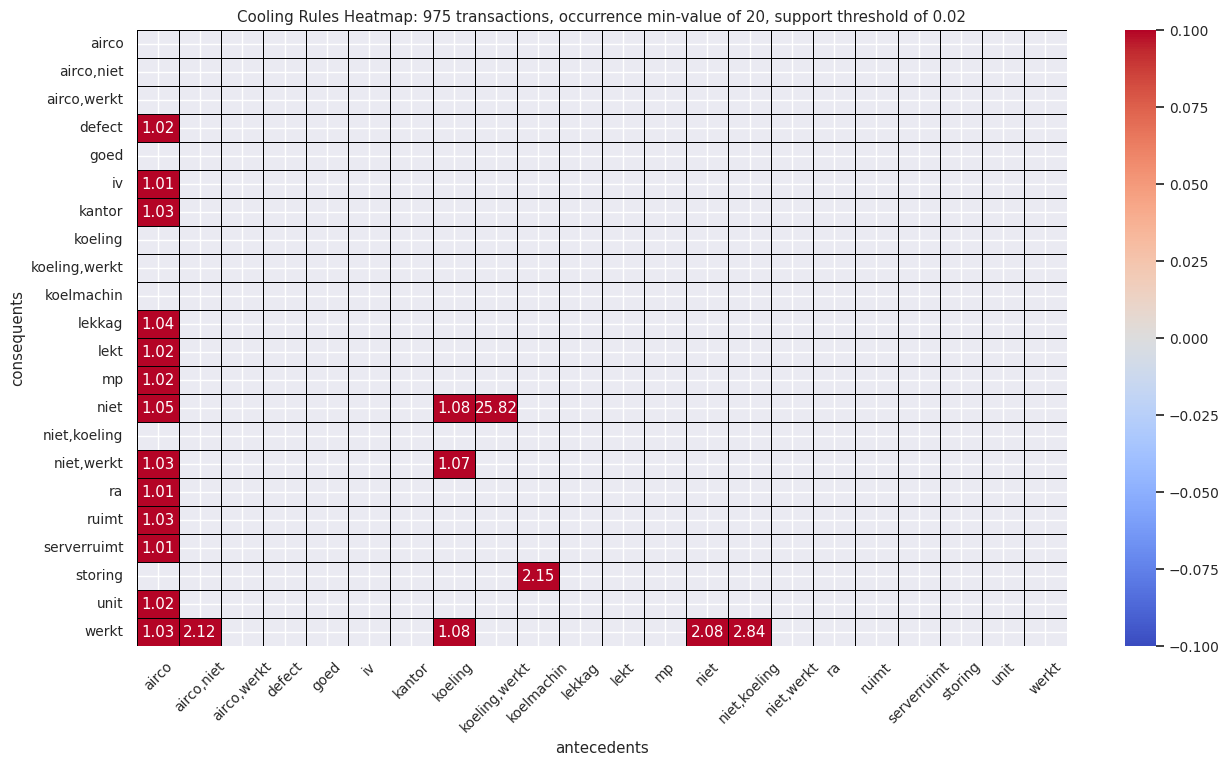

In [ ]:
# Step 1: Transform the association rules data into a pivot table for the heatmap.
# The pivot table uses 'consequents' as the row index and 'antecedents' as the columns, with 'conviction' values as the matrix.
pivot = rules_cooling.pivot(index='consequents', columns='antecedents', values='conviction')

# Step 2: Create a mask for the upper triangle of the heatmap to avoid duplicate values being displayed.
mask = np.triu(np.ones_like(pivot, dtype=bool))

# Step 3: Set the font scale for the heatmap.
sns.set(font_scale=0.9)

# Step 4: Create the heatmap figure.
plt.figure(figsize=(15, 8))

# Step 5: Generate the heatmap using seaborn.
heatmap = sns.heatmap(pivot,  # The pivot table containing support values.
                      cmap='coolwarm',  # Use the 'coolwarm' color palette.
                      mask=mask,  # Apply the mask to hide the upper triangle of the heatmap.
                      cbar=True,  # Show the color bar indicating the support values.
                      linewidths=0.5,  # Set the width of the grid lines.
                      linecolor='black',  # Set the color of the grid lines.
                      annot=True,  # Annotate each cell with the support value.
                      fmt='.2f')  # Format the annotations to two decimal places.

# Step 6: Customize the heatmap.
plt.xticks(rotation=45) # Rotate the x-axis labels 45 degrees for better readability.
plt.title(f'Cooling Rules Heatmap: {len(onehot_cooling)} transactions, occurrence min-value of {n}, support threshold of {minimum_support:.2f}') # Set the heatmap title.
plt.yticks(rotation=0) # Keep the y-axis labels horizontal.

# Step 7: Save the heatmap as an image file. Change the output path in case of need!
plt.savefig('/content/drive/MyDrive/Kropman/figures/Association Rule Mining/cooling/conviction_heatmap.png')

# Step 8: Display the heatmap.
plt.show()

## Frequency table

### Prepare items

In [ ]:
# Step 1: Combine 'antecedents' and 'consequents' of each rule into a single 'itemset' string for easier handling.
rules_cooling['itemset'] = rules_cooling.apply(lambda row: f"{row['antecedents']},{row['consequents']}", axis=1)

# Step 2: Calculate the absolute count of each itemset's occurrence by multiplying the support value by the total number of transactions.
# The number of transactions is determined by the length of the onehot_cooling matrix.
rules_cooling['count'] = rules_cooling.apply(lambda row: int(row['support'] * len(onehot_cooling)), axis=1)

# Step 3: Convert the 'itemset' string into a Python set to facilitate further itemset manipulations.
rules_cooling['itemset'] = rules_cooling['itemset'].apply(convert_str_to_set)

# Step 4: Format the support values to three decimal places and store them in a new column 'rounded_support'.
rules_cooling['rounded_support'] = rules_cooling.apply(lambda row: f"{row['support']:.3f}", axis=1)

# Step 5: Calculate the percentage occurrence of each itemset and format the result with two decimal places and a '%' symbol.
rules_cooling['percentage'] = rules_cooling.apply(lambda row: f"{row['count'] * 100 / len(onehot_cooling):.2f}%", axis=1)

# Step 6: Round the conviction values to three decimal places and store them in a new column 'rounded_conviction' for easier reading.
rules_cooling['rounded_conviction'] = rules_cooling.apply(lambda row: f"{row['conviction']:.3f}", axis=1)

# Step 7: Sort the DataFrame based on conviction values in descending order to prioritize rules with higher conviction.
rules_cooling.sort_values(by='conviction', ascending=False, inplace=True)

# Step 8: Remove duplicate itemsets based on the 'itemset' column, keeping only the first occurrence.
rules_cooling.drop_duplicates(subset=['itemset'], keep='first', inplace=True)

# Step 9: Reset the index of the DataFrame to maintain consistency after sorting and dropping duplicates.
rules_cooling.reset_index(inplace=True)

# Output the final processed DataFrame.
rules_cooling

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,index,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,itemset,count,rounded_support,percentage,rounded_conviction
0,25,goed,niet,0.020513,0.167179,0.020513,1.000000,5.981595,0.017083,inf,0.850262,"{niet, goed}",20,0.021,2.05%,inf
1,35,"airco,werkt",niet,0.059487,0.167179,0.059487,1.000000,5.981595,0.049542,inf,0.885496,"{airco, niet, werkt}",58,0.059,5.95%,inf
2,33,werkt,niet,0.095385,0.167179,0.094359,0.989247,5.917277,0.078413,77.452308,0.918626,"{niet, werkt}",92,0.094,9.44%,77.452
3,42,"koeling,werkt",niet,0.031795,0.167179,0.030769,0.967742,5.788640,0.025454,25.817436,0.854414,"{niet, koeling, werkt}",30,0.031,3.08%,25.817
4,17,ruimt,airco,0.038974,0.500513,0.031795,0.815789,1.629907,0.012288,2.711502,0.402141,"{airco, ruimt}",31,0.032,3.18%,2.712
5,8,lekt,airco,0.031795,0.500513,0.025641,0.806452,1.611251,0.009727,2.580684,0.391822,"{lekt, airco}",25,0.026,2.56%,2.581
6,5,kantor,airco,0.042051,0.500513,0.032821,0.780488,1.559376,0.011773,2.275442,0.374465,"{airco, kantor}",32,0.033,3.28%,2.275
7,11,mp,airco,0.035897,0.500513,0.027692,0.771429,1.541276,0.009725,2.185256,0.364263,"{airco, mp}",27,0.028,2.77%,2.185
8,30,koelmachin,storing,0.125128,0.346667,0.087179,0.696721,2.009773,0.043802,2.154234,0.574291,"{koelmachin, storing}",85,0.087,8.72%,2.154
9,7,lekkag,airco,0.071795,0.500513,0.053333,0.742857,1.484192,0.017399,1.942450,0.351466,"{airco, lekkag}",52,0.053,5.33%,1.942


### Show Heating Rules

In [ ]:
# Sort values by 'support' column.
rules_cooling.sort_values(by='support', ascending=False, inplace=True)

# Add the index as a column.
rules_cooling.reset_index(inplace=True)
rules_cooling.rename(columns={'index': 'index'}, inplace=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


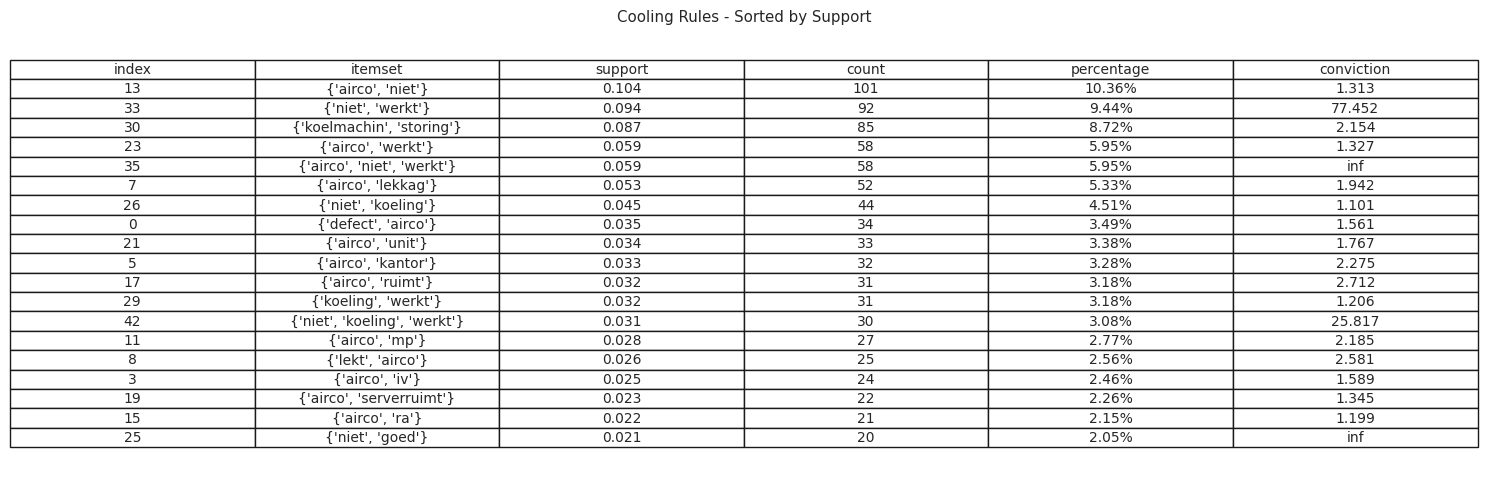

In [ ]:
# Step 1: Sort the 'rules_cooling' DataFrame in descending order by the 'support' column.
rules_cooling.sort_values(by='support', ascending=False, inplace=True)

# Step 2: Create a matplotlib subplot with a figure size of 15x5 inches to accommodate the table.
fig, ax = plt.subplots(figsize=(15, 5))

# Step 3: Turn off the axis display to hide axis lines and labels.
ax.axis('tight')
ax.axis('off')

# Step 4: Create a table using the sorted 'rules_cooling' DataFrame.
# 'cellText' contains the corresponding table data for the specified columns.
# 'colLabels' provides the actual column headers for the table.
table = ax.table(cellText=rules_cooling[['index', 'itemset', 'rounded_support', 'count', 'percentage', 'rounded_conviction']].values,
                 colLabels=rules_cooling[['index', 'itemset', 'support', 'count', 'percentage', 'conviction']].columns,
                 cellLoc='center', loc='center', fontsize=15)  # Set table cell font size to 15.

# Step 5: Disable auto font size scaling for the table and manually set the font size to 10.
table.auto_set_font_size(False)
table.set_fontsize(10)

# Step 6: Set the title of the table plot, indicating that the rules are sorted by support.
plt.title('Cooling Rules - Sorted by Support')

# Step 7: Adjust the layout to prevent any overlap and ensure the table fits within the figure dimensions.
plt.tight_layout()

# Step 8: Save the table as an image file with the specified path and ensure no extra white space around the image.
# Change the saving path in case of need!
plt.savefig('/content/drive/MyDrive/Kropman/figures/Association Rule Mining/cooling/itemsets_frequency_table.png', bbox_inches='tight')

# Step 9: Display the table plot.
plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


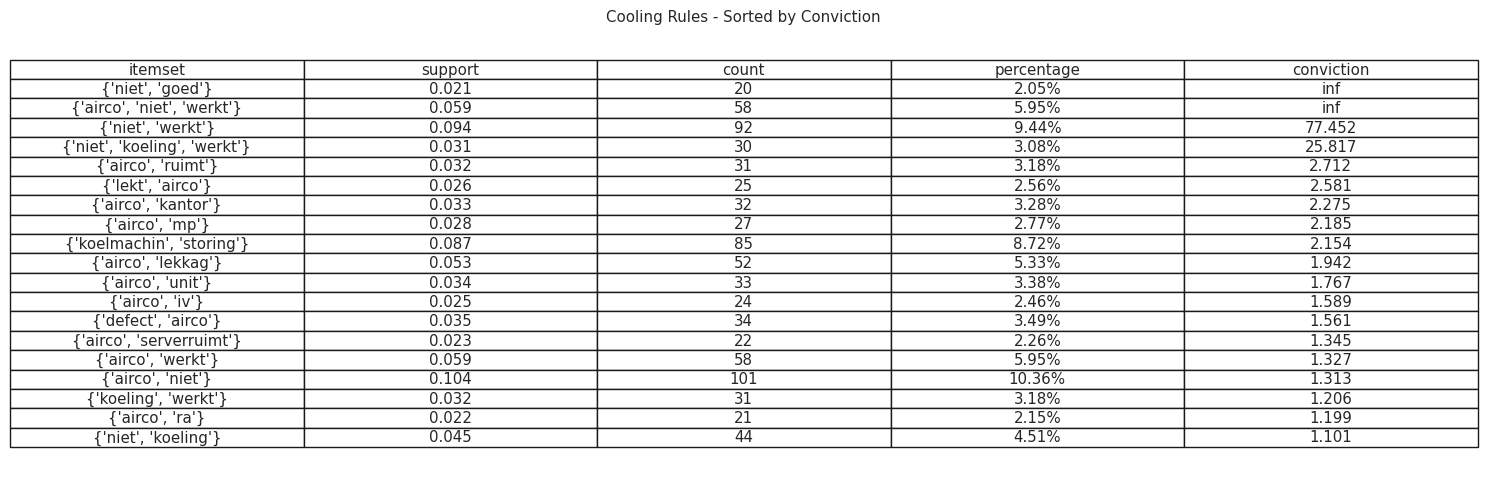

In [ ]:
# Step 1: Sort the 'rules_cooling' DataFrame in descending order by the 'conviction' column.
rules_cooling.sort_values(by='conviction', ascending=False, inplace=True)

# Step 2: Create a matplotlib subplot with a figure size of 15x5 inches to accommodate the table.
fig, ax = plt.subplots(figsize=(15, 5))

# Step 3: Turn off the axis display to hide axis lines and labels.
ax.axis('tight')
ax.axis('off')

# Step 4: Create a table using the sorted 'rules_cooling' DataFrame.
# 'cellText' contains the corresponding table data for the specified columns.
# 'colLabels' provides the actual column headers for the table.
table = ax.table(cellText=rules_cooling[['itemset', 'rounded_support', 'count', 'percentage', 'rounded_conviction']].values,
         colLabels=rules_cooling[['itemset', 'support', 'count', 'percentage', 'conviction']].columns,
         cellLoc='center', loc='center', fontsize=15)  # Set table cell font size to 15.

# Step 5: Set the title of the table plot, indicating that the rules are sorted by conviction.
plt.title('Cooling Rules - Sorted by Conviction')

# Step 6: Adjust the layout to prevent any overlap and ensure the table fits within the figure dimensions.
plt.tight_layout()

# Step 7: Display the table plot.
plt.show()

# Frequency Analysis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-28-dbe76a32951f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_so_cleaned_cooling['Year'] = df_so_cleaned_cooling['SO_Orderdatum (Begindatum)'].dt.year


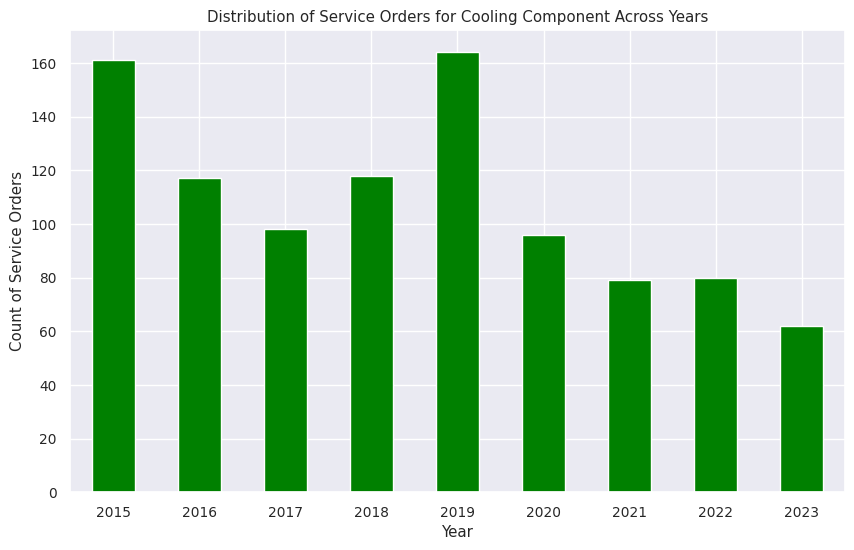

In [ ]:
# Step 1: Extract the year from the 'SO_Orderdatum (Begindatum)' datetime column
df_so_cleaned_cooling['Year'] = df_so_cleaned_cooling['SO_Orderdatum (Begindatum)'].dt.year

# Step 2: Count the occurrences of each year and sort them in ascending order
year_counts = df_so_cleaned_cooling['Year'].value_counts().sort_index()

# Step 3: Create a figure for the bar plot with specified dimensions (10x6 inches)
plt.figure(figsize=(10, 6))

# Step 4: Plot the year counts as a bar chart with green color
year_counts.plot(kind='bar', color='green')

# Step 5: Set the x-axis label
plt.xlabel('Year')

# Step 6: Set the y-axis label
plt.ylabel('Count of Service Orders')

# Step 7: Set the title of the plot to indicate what is being displayed
plt.title('Distribution of Service Orders for Cooling Component Across Years')

# Step 8: Rotate x-axis tick labels to 0 degrees for better visibility
plt.xticks(rotation=0)

# Step 9: Save the plot as a PNG file with specified path
plt.savefig('/content/drive/MyDrive/Kropman/figures/Frequency/cooling/yearly_distribution.png')

# Step 10: Display the plot
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-29-c073ffd0399f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_so_cleaned_cooling['Month'] = df_so_cleaned_cooling['SO_Orderdatum (Begindatum)'].dt.month


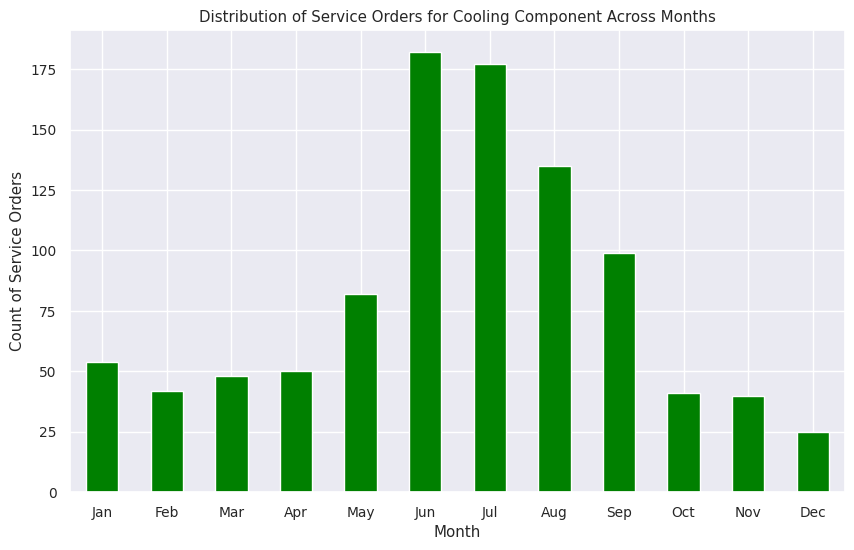

In [ ]:
# Step 1: Extract the month from the 'SO_Orderdatum (Begindatum)' datetime column
df_so_cleaned_cooling['Month'] = df_so_cleaned_cooling['SO_Orderdatum (Begindatum)'].dt.month

# Step 2: Count the occurrences of each month and sort them in ascending order
month_counts = df_so_cleaned_cooling['Month'].value_counts().sort_index()

# Step 3: Create a figure for the bar plot with specified dimensions (10x6 inches)
plt.figure(figsize=(10, 6))

# Step 4: Plot the month counts as a bar chart with green color
month_counts.plot(kind='bar', color='green')

# Step 5: Set the x-axis label to indicate that it represents months
plt.xlabel('Month')

# Step 6: Set the y-axis label to indicate that it represents the count of service orders
plt.ylabel('Count of Service Orders')

# Step 7: Set the title of the plot to indicate what is being displayed
plt.title('Distribution of Service Orders for Cooling Component Across Months')

# Step 8: Set the x-axis ticks to represent month labels and rotate them to 0 degrees for clarity
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=0)

# Step 9: Save the plot as a PNG file with the specified path
plt.savefig('/content/drive/MyDrive/Kropman/figures/Frequency/cooling/monthly_distribution.png')

# Step 10: Display the plot
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-30-70abe1fb12d8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_so_cleaned_cooling['Season'] = df_so_cleaned_cooling['Month'].apply(get_season)


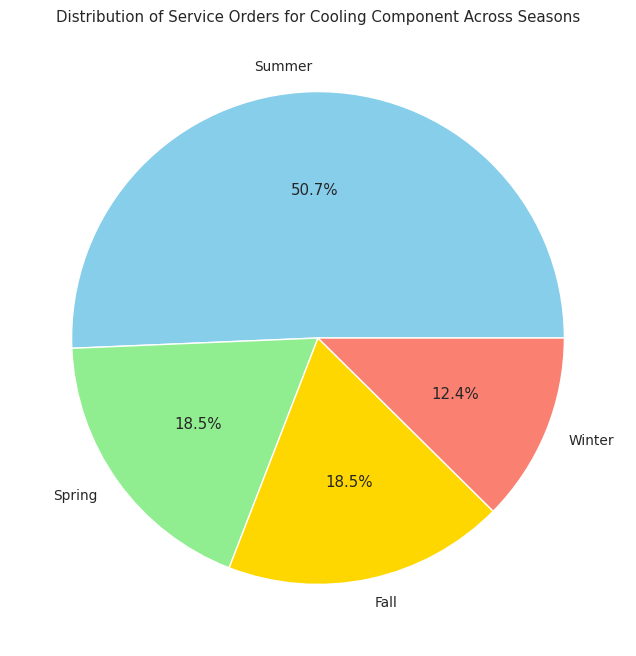

In [ ]:
# Step 1: Apply the get_season function to the 'Month' column to create a new 'Season' column.
df_so_cleaned_cooling['Season'] = df_so_cleaned_cooling['Month'].apply(get_season)

# Step 2: Count the occurrences of each season in the 'Season' column.
season_counts = df_so_cleaned_cooling['Season'].value_counts()

# Step 3: Create a figure for the pie chart with specified dimensions (8x8 inches).
plt.figure(figsize=(8, 8))

# Step 4: Plot the season counts as a pie chart with percentage labels.
season_counts.plot(kind='pie', autopct='%1.1f%%', colors=['skyblue', 'lightgreen', 'gold', 'salmon'])

# Step 5: Remove the y-label for better visual appearance.
plt.ylabel('')

# Step 6: Set the title of the pie chart to indicate what is being displayed.
plt.title('Distribution of Service Orders for Cooling Component Across Seasons')

# Step 7: Save the pie chart as a PNG file with the specified path.
plt.savefig('/content/drive/MyDrive/Kropman/figures/Frequency/cooling/seasonal_distribution.png')

# Step 8: Display the pie chart.
plt.show()